In [74]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm


In [119]:
with open('/home/f20222001/test-venv/UHI/Datasets_processed/inputs_36_v_clean_10k.pkl', 'rb') as f, open('/home/f20222001/test-venv/UHI/Datasets_processed/targets_36_v_clean_10k.pkl','rb') as t:
    inputs = pickle.load(f)
    targets = pickle.load(t)
# Shuffle before splitting (preserves alignment of X and y)
X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2, random_state=42
)
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X_train, Y_train, test_size=0.2, random_state=42
# )
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=42
)

In [142]:
X_train.shape

(442856, 36, 17)

In [149]:
# Check where LST is <= 10
mask = X_train[:, :, 0] <= -1
mask

array([[False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(442856, 36))

In [152]:
sequences_with_low_LST = np.any(mask)

# Count how many sequences satisfy this condition
count_sequences = np.sum(sequences_with_low_LST)

print(f"Number of sequences with at least one LST <= C: {count_sequences}")


Number of sequences with at least one LST <= C: 1


In [146]:
mask

array([[False,  True, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False,  True,  True, ..., False, False,  True]],
      shape=(442856, 36))

In [120]:
# Indexes of features to normalize
norm_idx = [0, 1, 2, 3] 

# Flatten for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_val_flat   = X_val.reshape(-1, X_val.shape[2])
X_test_flat  = X_test.reshape(-1, X_test.shape[2])

# Initialize arrays to hold the scaled data
X_train_scaled = X_train_flat.copy()
X_val_scaled   = X_val_flat.copy()
X_test_scaled  = X_test_flat.copy()

scaler = StandardScaler()

# Fit on train, transform all
X_train_scaled[:, norm_idx] = scaler.fit_transform(X_train_flat[:, norm_idx])
X_val_scaled[:, norm_idx]   = scaler.transform(X_val_flat[:, norm_idx])
X_test_scaled[:, norm_idx]  = scaler.transform(X_test_flat[:, norm_idx])

# Reshape back to 3D
X_train = X_train_scaled.reshape(X_train.shape)
X_val   = X_val_scaled.reshape(X_val.shape)
X_test  = X_test_scaled.reshape(X_test.shape)

# Flatten y
y_train_flat = Y_train.reshape(-1, 1)
y_val_flat   = Y_val.reshape(-1, 1)
y_test_flat  = Y_test.reshape(-1, 1)

# Standardize y
standard_scaler_y = StandardScaler()
y_train_scaled = standard_scaler_y.fit_transform(y_train_flat)
y_val_scaled   = standard_scaler_y.transform(y_val_flat)
y_test_scaled  = standard_scaler_y.transform(y_test_flat)

# Reshape back to original shape
Y_train = y_train_scaled.reshape(Y_train.shape)
Y_val   = y_val_scaled.reshape(Y_val.shape)
Y_test  = y_test_scaled.reshape(Y_test.shape)


In [79]:
X_train.shape

(442856, 36, 17)

In [80]:
X_train[0]

array([[ 2.61888772e-01, -8.85532379e-01,  1.13509929e+00,
        -3.41317922e-01, -5.00000000e-01,  8.66025388e-01,
         2.30000000e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00],
       [-6.92921042e-01, -1.28015852e+00,  1.00388861e+00,
        -3.50056648e-01,  5.00000000e-01,  8.66025388e-01,
         2.50000000e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00],
       [ 8.82784665e-01, -1.06953967e+00,  1.17577291e+00,
        -1.40598625e-01,  1.00000000e+00,  6.12323426e-17,
         2.70000000e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.0

In [81]:
Y_train.shape

(442856,)

In [82]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(Y_val, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [83]:
device = torch.device("cuda")
torch.cuda.set_device(3)  
device

device(type='cuda')

In [84]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=1536, num_layers=3, dropout=0.3):
        super(LSTMPredictor, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)  # Output = scalar

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
        last_time_step = lstm_out[:, -1, :]  # take the last time step's output
        out = self.fc(last_time_step)  # (batch_size, 1)
        return out.squeeze(1)  # final shape: (batch_size,)
    


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.10486119240522385


  1%|          | 1/100 [00:57<1:35:29, 57.87s/it]

Epoch 2/100 - Train Loss: 0.09767124056816101


  2%|▏         | 2/100 [01:56<1:35:00, 58.17s/it]

Epoch 3/100 - Train Loss: 0.08201700448989868


  3%|▎         | 3/100 [02:54<1:34:11, 58.26s/it]

Epoch 4/100 - Train Loss: 0.05242162197828293


  4%|▍         | 4/100 [03:53<1:33:20, 58.34s/it]

Epoch 5/100 - Train Loss: 0.07805448025465012


  5%|▌         | 5/100 [04:51<1:32:24, 58.36s/it]

Epoch 6/100 - Train Loss: 0.11216892302036285


  6%|▌         | 6/100 [05:49<1:31:28, 58.38s/it]

Epoch 7/100 - Train Loss: 0.09467868506908417


  7%|▋         | 7/100 [06:48<1:30:35, 58.44s/it]

Epoch 8/100 - Train Loss: 0.06603167206048965


  8%|▊         | 8/100 [07:46<1:29:35, 58.43s/it]

Epoch 9/100 - Train Loss: 0.044951681047677994


  9%|▉         | 9/100 [08:45<1:28:37, 58.43s/it]

Epoch 10/100 - Train Loss: 0.07759188115596771


 10%|█         | 10/100 [09:43<1:27:37, 58.42s/it]

Epoch 11/100 - Train Loss: 0.0425850935280323


 11%|█         | 11/100 [10:42<1:26:39, 58.42s/it]

Epoch 12/100 - Train Loss: 0.04910137504339218


 12%|█▏        | 12/100 [11:40<1:25:44, 58.46s/it]

Epoch 13/100 - Train Loss: 0.04663515463471413


 13%|█▎        | 13/100 [12:39<1:24:43, 58.43s/it]

Epoch 14/100 - Train Loss: 0.0534561350941658


 14%|█▍        | 14/100 [13:37<1:23:46, 58.45s/it]

Epoch 15/100 - Train Loss: 0.03247012943029404


 15%|█▌        | 15/100 [14:35<1:22:47, 58.45s/it]

Epoch 16/100 - Train Loss: 0.03290770202875137


 16%|█▌        | 16/100 [15:34<1:21:49, 58.45s/it]

Epoch 17/100 - Train Loss: 0.09409199655056


 17%|█▋        | 17/100 [16:32<1:20:53, 58.48s/it]

Epoch 18/100 - Train Loss: 0.03348171338438988


 18%|█▊        | 18/100 [17:31<1:19:53, 58.46s/it]

Epoch 19/100 - Train Loss: 0.04895246773958206


 19%|█▉        | 19/100 [18:29<1:18:54, 58.45s/it]

Epoch 20/100 - Train Loss: 0.047334834933280945


 20%|██        | 20/100 [19:28<1:17:53, 58.42s/it]

Epoch 21/100 - Train Loss: 0.04440201073884964


 21%|██        | 21/100 [20:26<1:16:55, 58.42s/it]

Epoch 22/100 - Train Loss: 0.04653684422373772


 22%|██▏       | 22/100 [21:25<1:15:59, 58.46s/it]

Epoch 23/100 - Train Loss: 0.03064040094614029


 23%|██▎       | 23/100 [22:23<1:14:58, 58.42s/it]

Epoch 24/100 - Train Loss: 0.03478796407580376


 24%|██▍       | 24/100 [23:21<1:13:58, 58.40s/it]

Epoch 25/100 - Train Loss: 0.02500535175204277


 25%|██▌       | 25/100 [24:20<1:12:59, 58.39s/it]

Epoch 26/100 - Train Loss: 0.02763841487467289


 26%|██▌       | 26/100 [25:18<1:12:01, 58.40s/it]

Epoch 27/100 - Train Loss: 0.02621058002114296


 27%|██▋       | 27/100 [26:17<1:11:04, 58.42s/it]

Epoch 28/100 - Train Loss: 0.026023371145129204


 28%|██▊       | 28/100 [27:15<1:10:04, 58.39s/it]

Epoch 29/100 - Train Loss: 0.029409587383270264


 29%|██▉       | 29/100 [28:13<1:09:06, 58.40s/it]

Epoch 30/100 - Train Loss: 0.06907327473163605


 30%|███       | 30/100 [29:12<1:08:08, 58.40s/it]

Epoch 31/100 - Train Loss: 0.024752607569098473


 31%|███       | 31/100 [30:10<1:07:09, 58.39s/it]

Epoch 32/100 - Train Loss: 0.028732357546687126


 32%|███▏      | 32/100 [31:09<1:06:13, 58.43s/it]

Epoch 33/100 - Train Loss: 0.02159522846341133


 33%|███▎      | 33/100 [32:07<1:05:13, 58.42s/it]

Epoch 34/100 - Train Loss: 0.026688972488045692


 34%|███▍      | 34/100 [33:05<1:04:15, 58.42s/it]

Epoch 35/100 - Train Loss: 0.030473051592707634


 35%|███▌      | 35/100 [34:04<1:03:15, 58.39s/it]

Epoch 36/100 - Train Loss: 0.01975761167705059


 36%|███▌      | 36/100 [35:02<1:02:17, 58.40s/it]

Epoch 37/100 - Train Loss: 0.018503950908780098


 37%|███▋      | 37/100 [36:01<1:01:34, 58.65s/it]

Epoch 38/100 - Train Loss: 0.022350281476974487


 38%|███▊      | 38/100 [37:00<1:00:30, 58.56s/it]

Epoch 39/100 - Train Loss: 0.016529511660337448


 39%|███▉      | 39/100 [37:58<59:28, 58.50s/it]  

Epoch 40/100 - Train Loss: 0.021684547886252403


 40%|████      | 40/100 [38:56<58:27, 58.47s/it]

Epoch 41/100 - Train Loss: 0.019131015986204147


 41%|████      | 41/100 [39:55<57:27, 58.43s/it]

Epoch 42/100 - Train Loss: 0.01563957706093788


 42%|████▏     | 42/100 [40:53<56:29, 58.44s/it]

Epoch 43/100 - Train Loss: 0.014590301550924778


 43%|████▎     | 43/100 [41:52<55:28, 58.40s/it]

Epoch 44/100 - Train Loss: 0.012861757539212704


 44%|████▍     | 44/100 [42:50<54:30, 58.40s/it]

Epoch 45/100 - Train Loss: 0.009279820136725903


 45%|████▌     | 45/100 [43:48<53:31, 58.38s/it]

Epoch 46/100 - Train Loss: 0.014907458797097206


 46%|████▌     | 46/100 [44:47<52:32, 58.39s/it]

Epoch 47/100 - Train Loss: 0.01738470420241356


 47%|████▋     | 47/100 [45:45<51:35, 58.41s/it]

Epoch 48/100 - Train Loss: 0.010431560687720776


 48%|████▊     | 48/100 [46:44<50:36, 58.39s/it]

Epoch 49/100 - Train Loss: 0.012418780475854874


 49%|████▉     | 49/100 [47:42<49:37, 58.38s/it]

Epoch 50/100 - Train Loss: 0.008438569493591785


 50%|█████     | 50/100 [48:40<48:38, 58.36s/it]

Epoch 51/100 - Train Loss: 0.008152457885444164


 51%|█████     | 51/100 [49:39<47:40, 58.37s/it]

Epoch 52/100 - Train Loss: 0.009545573964715004


 52%|█████▏    | 52/100 [50:37<46:43, 58.41s/it]

Epoch 53/100 - Train Loss: 0.007995027117431164


 53%|█████▎    | 53/100 [51:35<45:43, 58.38s/it]

Epoch 54/100 - Train Loss: 0.006625339388847351


 54%|█████▍    | 54/100 [52:34<44:45, 58.38s/it]

Epoch 55/100 - Train Loss: 0.007820496335625648


 55%|█████▌    | 55/100 [53:32<43:46, 58.37s/it]

Epoch 56/100 - Train Loss: 0.01156252808868885


 56%|█████▌    | 56/100 [54:31<42:48, 58.37s/it]

Epoch 57/100 - Train Loss: 0.010158258490264416


 57%|█████▋    | 57/100 [55:29<41:49, 58.36s/it]

Epoch 58/100 - Train Loss: 0.008135857991874218


 58%|█████▊    | 58/100 [56:27<40:50, 58.34s/it]

Epoch 59/100 - Train Loss: 0.005596688482910395


 59%|█████▉    | 59/100 [57:26<39:52, 58.35s/it]

Epoch 60/100 - Train Loss: 0.005674196407198906


 60%|██████    | 60/100 [58:24<38:53, 58.33s/it]

Epoch 61/100 - Train Loss: 0.006470903754234314


 61%|██████    | 61/100 [59:22<37:54, 58.33s/it]

Epoch 62/100 - Train Loss: 0.005730480886995792


 62%|██████▏   | 62/100 [1:00:21<36:58, 58.37s/it]

Epoch 63/100 - Train Loss: 0.00505387969315052


 63%|██████▎   | 63/100 [1:01:19<35:58, 58.35s/it]

Epoch 64/100 - Train Loss: 0.004150301683694124


 64%|██████▍   | 64/100 [1:02:17<35:00, 58.35s/it]

Epoch 65/100 - Train Loss: 0.005747694056481123


 65%|██████▌   | 65/100 [1:03:16<34:01, 58.33s/it]

Epoch 66/100 - Train Loss: 0.005539038684219122


 66%|██████▌   | 66/100 [1:04:14<33:04, 58.36s/it]

Epoch 67/100 - Train Loss: 0.006412867456674576


 67%|██████▋   | 67/100 [1:05:12<32:07, 58.40s/it]

Epoch 68/100 - Train Loss: 0.013084604404866695


 68%|██████▊   | 68/100 [1:06:11<31:07, 58.37s/it]

Epoch 69/100 - Train Loss: 0.01867242529988289


 69%|██████▉   | 69/100 [1:07:09<30:09, 58.37s/it]

Epoch 70/100 - Train Loss: 0.004793929867446423


 70%|███████   | 70/100 [1:08:07<29:10, 58.36s/it]

Epoch 71/100 - Train Loss: 0.004983316175639629


 71%|███████   | 71/100 [1:09:06<28:12, 58.34s/it]

Epoch 72/100 - Train Loss: 0.004447700455784798


 72%|███████▏  | 72/100 [1:10:04<27:14, 58.38s/it]

Epoch 73/100 - Train Loss: 0.0033767486456781626


 73%|███████▎  | 73/100 [1:11:03<26:16, 58.37s/it]

Epoch 74/100 - Train Loss: 0.004437713883817196


 74%|███████▍  | 74/100 [1:12:01<25:17, 58.38s/it]

Epoch 75/100 - Train Loss: 0.00375401065684855


 75%|███████▌  | 75/100 [1:12:59<24:18, 58.35s/it]

Epoch 76/100 - Train Loss: 0.005204393994063139


 76%|███████▌  | 76/100 [1:13:58<23:20, 58.35s/it]

Epoch 77/100 - Train Loss: 0.005635953042656183


 77%|███████▋  | 77/100 [1:14:56<22:23, 58.40s/it]

Epoch 78/100 - Train Loss: 0.003692512633278966


 78%|███████▊  | 78/100 [1:15:54<21:24, 58.38s/it]

Epoch 79/100 - Train Loss: 0.0031241774559020996


 79%|███████▉  | 79/100 [1:16:53<20:25, 58.38s/it]

Epoch 80/100 - Train Loss: 0.0037132566794753075


 80%|████████  | 80/100 [1:17:51<19:27, 58.36s/it]

Epoch 81/100 - Train Loss: 0.008042396977543831


 81%|████████  | 81/100 [1:18:50<18:28, 58.36s/it]

Epoch 82/100 - Train Loss: 0.005031455308198929


 82%|████████▏ | 82/100 [1:19:48<17:30, 58.38s/it]

Epoch 83/100 - Train Loss: 0.005913295317441225


 83%|████████▎ | 83/100 [1:20:46<16:31, 58.35s/it]

Epoch 84/100 - Train Loss: 0.0033869168255478144


 84%|████████▍ | 84/100 [1:21:45<15:33, 58.36s/it]

Epoch 85/100 - Train Loss: 0.002740129129961133


 85%|████████▌ | 85/100 [1:22:43<14:35, 58.35s/it]

Epoch 86/100 - Train Loss: 0.0029980093240737915


 86%|████████▌ | 86/100 [1:23:41<13:36, 58.35s/it]

Epoch 87/100 - Train Loss: 0.0027776998467743397


 87%|████████▋ | 87/100 [1:24:40<12:39, 58.39s/it]

Epoch 88/100 - Train Loss: 0.0028334278613328934


 88%|████████▊ | 88/100 [1:25:38<11:40, 58.37s/it]

Epoch 89/100 - Train Loss: 0.003001528326421976


 89%|████████▉ | 89/100 [1:26:36<10:42, 58.37s/it]

Epoch 90/100 - Train Loss: 0.0029920656234025955


 90%|█████████ | 90/100 [1:27:35<09:43, 58.35s/it]

Epoch 91/100 - Train Loss: 0.003161761211231351


 91%|█████████ | 91/100 [1:28:33<08:45, 58.37s/it]

Epoch 92/100 - Train Loss: 0.002995115704834461


 92%|█████████▏| 92/100 [1:29:32<07:47, 58.41s/it]

Epoch 93/100 - Train Loss: 0.0034622703678905964


 93%|█████████▎| 93/100 [1:30:30<06:48, 58.38s/it]

Epoch 94/100 - Train Loss: 0.0034871469251811504


 94%|█████████▍| 94/100 [1:31:28<05:50, 58.38s/it]

Epoch 95/100 - Train Loss: 0.0034699048846960068


 95%|█████████▌| 95/100 [1:32:27<04:51, 58.36s/it]

Epoch 96/100 - Train Loss: 0.0031159077771008015


 96%|█████████▌| 96/100 [1:33:25<03:53, 58.37s/it]

Epoch 97/100 - Train Loss: 0.004478164948523045


 97%|█████████▋| 97/100 [1:34:24<02:55, 58.40s/it]

Epoch 98/100 - Train Loss: 0.003918378613889217


 98%|█████████▊| 98/100 [1:35:22<01:56, 58.38s/it]

Epoch 99/100 - Train Loss: 0.0025742549914866686


 99%|█████████▉| 99/100 [1:36:20<00:58, 58.38s/it]

Epoch 100/100 - Train Loss: 0.0029072316829115152


100%|██████████| 100/100 [1:37:19<00:00, 58.39s/it]


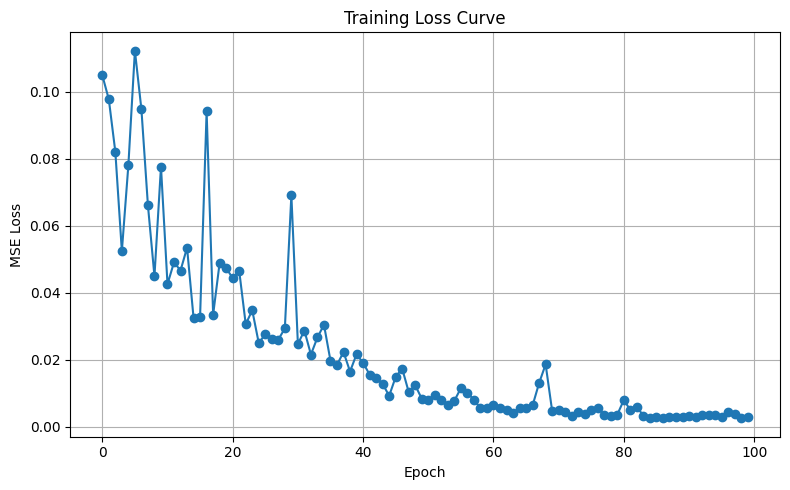

In [90]:
input_size = X_train.shape[2]  # num_features per timestep
model = LSTMPredictor(input_size=input_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Training loop
num_epochs = 100
train_losses = []
val_losses = {
    "mse": [],
    "rmse": [],
    "mae": [],
    "r2": []
}

for epoch in tqdm(range(num_epochs)):
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print(batch_x.shape)
        #print(batch_y.shape)
        # Forward
        preds = model(batch_x)  # shape: (batch_size,)
        #print(preds.shape)
        loss = criterion(preds, batch_y)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item()}")
    train_losses.append(loss.item())

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)

            preds = model(val_x)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(val_y.cpu().numpy())

    # Concatenate and inverse scale
    all_preds_np = np.concatenate(all_preds).reshape(-1, 1)
    all_targets_np = np.concatenate(all_targets).reshape(-1, 1)

    y_pred = standard_scaler_y.inverse_transform(all_preds_np)
    y_true = standard_scaler_y.inverse_transform(all_targets_np)

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    val_losses["mse"].append(mse)
    val_losses["rmse"].append(rmse)
    val_losses["mae"].append(mae)
    val_losses["r2"].append(r2)


plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_epochs),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

# Unnormalize using RobustScaler
y_true = standard_scaler_y.inverse_transform(y_true)
y_pred = standard_scaler_y.inverse_transform(y_pred)

# Flatten back
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape=mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")
print(f"Test MAPE:   {mape:.4f}")

Test MSE:  2.4695
Test RMSE: 1.5715
Test MAE:  0.8570
Test R²:   0.9670
Test MAPE:   0.0349


In [92]:
val_losses['mae']

[1.9553983211517334,
 1.514999508857727,
 1.4081909656524658,
 1.3859654664993286,
 1.3225610256195068,
 1.3745356798171997,
 1.3201944828033447,
 1.2935489416122437,
 1.3755741119384766,
 1.206913709640503,
 1.2198110818862915,
 1.1920901536941528,
 1.2552978992462158,
 1.1887307167053223,
 1.2156598567962646,
 1.1579583883285522,
 1.1463592052459717,
 1.1455050706863403,
 1.1478222608566284,
 1.1058892011642456,
 1.0890876054763794,
 1.083741545677185,
 1.085436463356018,
 1.0648510456085205,
 1.0505094528198242,
 1.061055302619934,
 1.0259495973587036,
 1.0265663862228394,
 1.0558655261993408,
 1.1306508779525757,
 1.0702440738677979,
 1.007867693901062,
 1.0247361660003662,
 0.9988894462585449,
 1.0559699535369873,
 0.993623673915863,
 1.0007611513137817,
 0.9788379669189453,
 0.9755593538284302,
 0.9882909059524536,
 0.9843226075172424,
 1.0079286098480225,
 0.9980086088180542,
 0.9480792880058289,
 0.936301589012146,
 0.9420141577720642,
 0.959843099117279,
 0.9626621007919312,
 

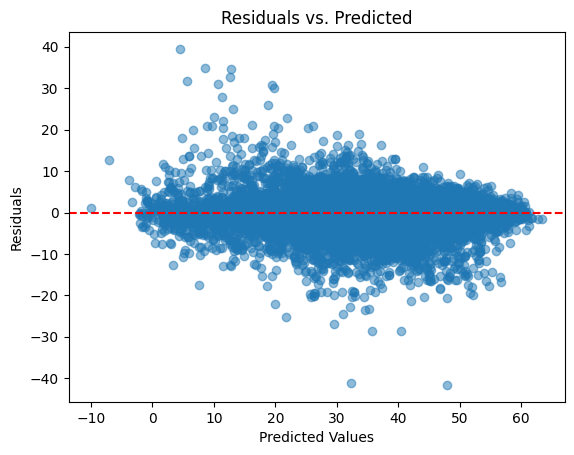

In [93]:
residuals=y_true-y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()


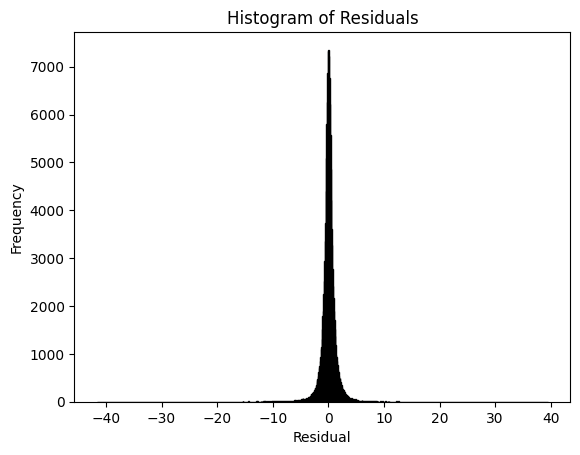

In [94]:
plt.hist(residuals, bins=1000, edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [ ]:
abs_error=np.abs(residuals)
x_temp=X_test.reshape(-1,17)
x_temp[:,norm_idx] = scaler.inverse_transform(x_temp[:,norm_idx])
x_temp=x_temp.reshape(X_test.shape)


In [127]:
high_error_mask = abs_error > 20
high_error_X = x_temp[high_error_mask]
high_error_y_true = y_true[high_error_mask]
high_error_y_pred = y_pred[high_error_mask]
high_error_indices = np.where(high_error_mask)[0]


In [128]:

for idx in high_error_indices:
    print(f"Index: {idx}")
    print("Input Sequence:", x_temp[idx][:,0])
    print("True Value:", y_true[idx])
    print("Predicted Value:", y_pred[idx])
    print("Error:", abs_error[idx])
    print("---")


Index: 2924
Input Sequence: [35.897076 45.481205 46.258804 51.252533 33.774487 38.96646  32.66705
 33.482246 34.4974   43.722633 47.85502  45.821297 30.81619  36.70886
 34.005203 33.57624  39.624428 42.9006   45.394047 51.69004  37.604378
 34.59652  30.792265 31.263952 34.73837  41.712837 49.767403 49.27179
 44.83691  39.4108   30.433372 37.296757 42.839077 48.212204 52.43004
 23.356361]
True Value: -2.1283958
Predicted Value: 20.008625
Error: 22.13702
---
Index: 7613
Input Sequence: [33.550606 33.84968  38.56997  43.895245 52.558216 45.862316 34.842617
 31.68095  30.306906 37.161743 49.553776 47.089382 40.533623 29.346441
 28.821775 36.654167 41.22577  47.5098   53.00256  38.975006 34.764004
 31.73222  30.583765 33.680492 41.271915 48.875298 51.953228 34.11116
 33.229313 33.813793 31.814253 46.272476 16.725403 32.05693  34.760586
 45.804207]
True Value: 45.701668
Predicted Value: 25.383415
Error: 20.318253
---
Index: 7627
Input Sequence: [26.820526 38.13417  51.63193  39.562904 42.485

In [129]:
count = 0
for idx in high_error_indices:
    if np.any((x_temp[idx][:, 2] < -1) | (x_temp[idx][:, 2] > 1)):
        count += 1
count/len(high_error_indices)

0.0

In [130]:
y=x_temp[idx][:,2]<-1
y

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [131]:
high_error_indices

array([  2924,   7613,   7627,   8793,  12933,  19854,  21681,  27069,
        28455,  30297,  33610,  34968,  38784,  40222,  43232,  44945,
        45873,  62036,  66313,  69703,  78647,  81674,  84019,  84262,
        85332,  87667,  92837, 104953, 107491, 116717, 118844, 122394,
       125296, 125684, 126385, 126874, 126950, 133350, 141757, 141798,
       142826, 144573, 146229])

In [132]:
rmse = np.sqrt(np.mean((residuals) ** 2))
large_errors = residuals[np.abs(residuals) > 2 * rmse]
print(f"Number of large residuals: {len(large_errors)}")


Number of large residuals: 5717
